# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import userinput
from thermo import Chemical

In [2]:
#Properties of hot water
chemical = Chemical('water', T=(userinput.t_ATES_service + 273.15))
water_density = chemical.rho  # kg/m^3
specific_heat_capacity = chemical.Cpl  # J/(kg·K)
kinematic_viscosity = chemical.nu  # m^2/s
thermal_conductivity_water = chemical.kl  # Thermal conductivity of liquid phase (W/m·K) 0.6425006607115105

# Temperature, demand and electricity price

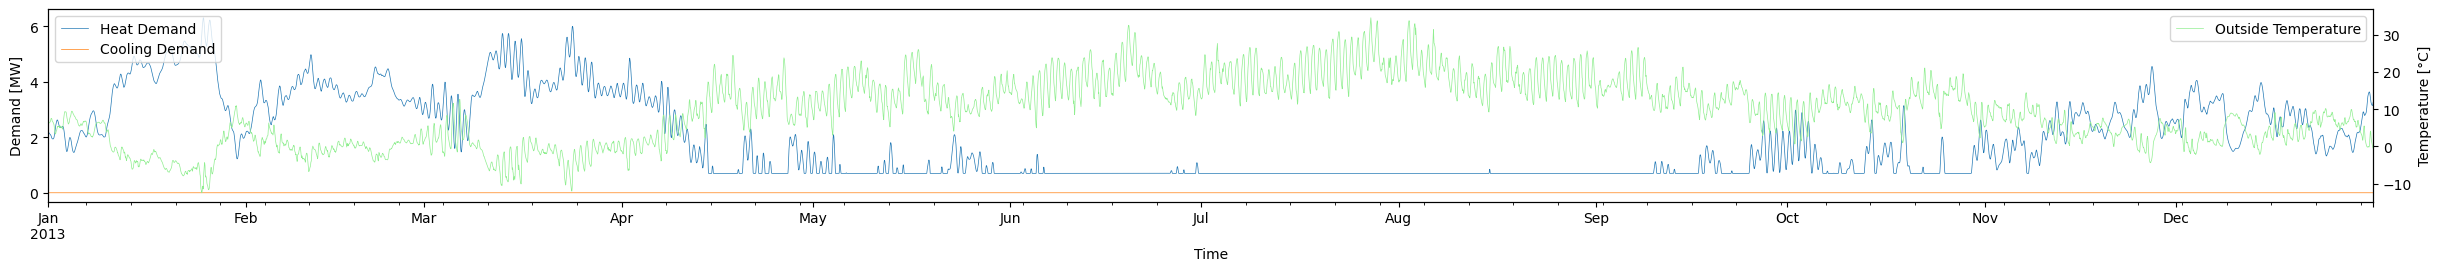

In [3]:
from functions import temperature_and_electricity_price
time_index_H, temperature_heat, heat_demand, cooling_demand, electricity_price, COP_hp = temperature_and_electricity_price()

# ATES Setup

Ground Analysis Berlin

In [4]:
RUN_GEO = False  # Set to True to re-run and save, False to load from file. True is important for changing the location in the ground data.

from functions import ATES_ground_analysis
groundlayers, df_ground_display = ATES_ground_analysis(RUN_GEO)
print(groundlayers.columns)
df_ground_display[['Thickness (m)', 'hydr. conductivity (m/s)', 'porosity -']].head(20).T

ImportError: cannot import name 'ATES_ground_analysis' from 'functions' (c:\Users\greif\.github\functions.py)

# Visual Analysis: Element 8 "Pre-Rupelian", at 46m thickness and a hydraulic conductivity of 6,5 e-7 m/s seems to be adequate, as hydraulic conductivity of the upper layer (Rupelian) is just around 5% of HolstPre-Rupelian
Alternativeley, Element 4 "Elsterian", at 100m thickness and a hydraulic conductivity of 9e-7 seems to be adequate Element 8 "Pre-Rupelian", at 46m thickness and a hydraulic conductivity of 6,5 e-7 m/s seems to be adequate as well, as hydraulic conductivity of the upper layer (Rupelian) is just around 5% of HolstPre-Rupelian, as hydraulic conductivity of Holstein and Rupelian are around 2 dimensions smaller. Miocene and Cottbus are neglected due to small Thickness.


In [ ]:
chosen_layer = 7
print("Chosen layer: ", groundlayers['Layer'].iloc[chosen_layer])
depth_ATES = groundlayers['Thickness (m)'].iloc[:chosen_layer].sum() + groundlayers['Thickness (m)'].iloc[chosen_layer] / 2
porosity = groundlayers['porosity -'].iloc[chosen_layer]  # Porosity of the chosen layer
density_solid = 2100 # kg/m^3 #nachprüfen
heat_capacity_solid = groundlayers['vol. heatcap. of solid(MJ/(m³·K))'].iloc[chosen_layer]*1000000 / density_solid # J/(kg·K)
lambda_stand = (groundlayers['th. conductivity (W/(m·K))'].iloc[chosen_layer])

#Following two lines are commented out because they are not used in the rest of the code due to alternating assumptions
#layer_thickness = groundlayers['Thickness (m)'].iloc[chosen_layer]
layer_thickness = 30 # m

#hydr_cond = groundlayers['hydr. conductivity (m/s)'].iloc[chosen_layer]

def calculate_ground_parameters(depth_ATES, temperature_ground= userinput.temperature_ground, heat_increase_ground=3.0):
    """
    Calculate temperature_ground, permeability, and hydr_cond for a given layer.
    """
    temperature_depth = temperature_ground + depth_ATES / 100 * heat_increase_ground  # Approximate temperature gradient of 3°C per 100m depth
    permeability = 1.75 * 9.87e-13  # permeability for reference system between 1.5 and 2.0 Darcy
    hydr_cond = permeability * 9.81 / Chemical('water', T=(temperature_depth + 273.15)).nu  # Convert Darcy to m/s
    print( "hydr_cond: ", round(hydr_cond, 8), "m/s")
    return temperature_depth, permeability, hydr_cond

# Example usage:
temperature_depth, permeability, hydr_cond = calculate_ground_parameters(depth_ATES)


Chosen layer:  Pre-Rupelian
hydr_cond:  1.517e-05 m/s


In [ ]:
from functions import ATES_complete_setup
ATES_max_power, phi_standing, phi_charge_ATES, phi_pipes, P_pump, Q_ATES_standing_mean = ATES_complete_setup(hydr_cond, layer_thickness, porosity, depth_ATES, temperature_depth, heat_capacity_solid, lambda_stand)

V_dot_max_ATES: 0.064 m3/s = 232.128 m3/h, ATES_max_power: 5.301 MW
r_hyd_max: 104.6 m, r_hyd_min: 33.1 m, water_volume: 306543.1 m3
Pipe Requirements:
Number of wells per ATES : 1, volumeflow per pipe final: 0.0645m3s, Pipe diameter: 280 mm, Pressure drop: 0.825 bar, Velocity: 1.047 m/s, alpha_in: 27427.0 W/m2K
System results:
dt:  0.0  K, Q_loss_pipes:  107.069  W, phi:  0.99998
ATES geometry:
Mean Radii: r_hyd: 63.7 m, r_th: 52.8 m, dr_ln: 58.1 m, water_volume per storage: 1032131.7 m3, surface medium velocity: 5.06e-06 m/s
Q loss ATES:
lambda_transmission: 2.48, lambda_convection: 24.83, added faktorterm: 46756.56985595018
Q ATES standing: 0.1 MW, Q loss charge: 1.2 MW
phi_standing: 0.99997281, dp_ATES: 5.0 bar, phi_charge_ATES: 0.82031647
power of pump: 0.044 MW


# Model Setup

from ATES_optimization import optimization, plot_results
m = optimization(depth_ATES, ATES_max_power, time_index_H, temperature_heat, phi_standing, phi_pipes, phi_charge_ATES, heat_demand, P_pump, COP_hp, electricity_price, drilling_costs=userinput.drilling_costs)

plot_results(m, time_index_H, heat_demand, electricity_price)


In [ ]:
from IPython.display import clear_output

df_results_I = pd.DataFrame(columns=[
    "hydr_cond", "layer_thickness", "depth_ATES", "porosity", "temperature_ground",
    "ATES_max_power", "phi_standing", "phi_charge_ATES", "phi_pipes", "P_pump", "Q_ATES_standing_mean"
])

for d in depth_ATES * np.array(userinput.d_analysis_factor):
    for hc in hydr_cond * np.array(userinput.hc_analysis_factor): 
        for lt in layer_thickness * np.array(userinput.lt_analysis_factor):
            for p in porosity * np.array(userinput.p_analysis_factor):

                temperature_ground, permeability, hydr_cond = calculate_ground_parameters(d)
                ATES_max_power, phi_standing, phi_charge_ATES, phi_pipes, P_pump, Q_ATES_standing_mean = ATES_complete_setup(
                    hc, lt, p, d, temperature_ground, heat_capacity_solid, lambda_stand
                )
                # Append new row to DataFrame
                df_results_I.loc[len(df_results_I)] = [
                    hc, lt, d, p, temperature_ground, ATES_max_power, phi_standing, phi_charge_ATES, phi_pipes, P_pump, Q_ATES_standing_mean
                ]

clear_output()

df_results_I.to_csv("ATES_sensitivity_results_I.csv", index=False)

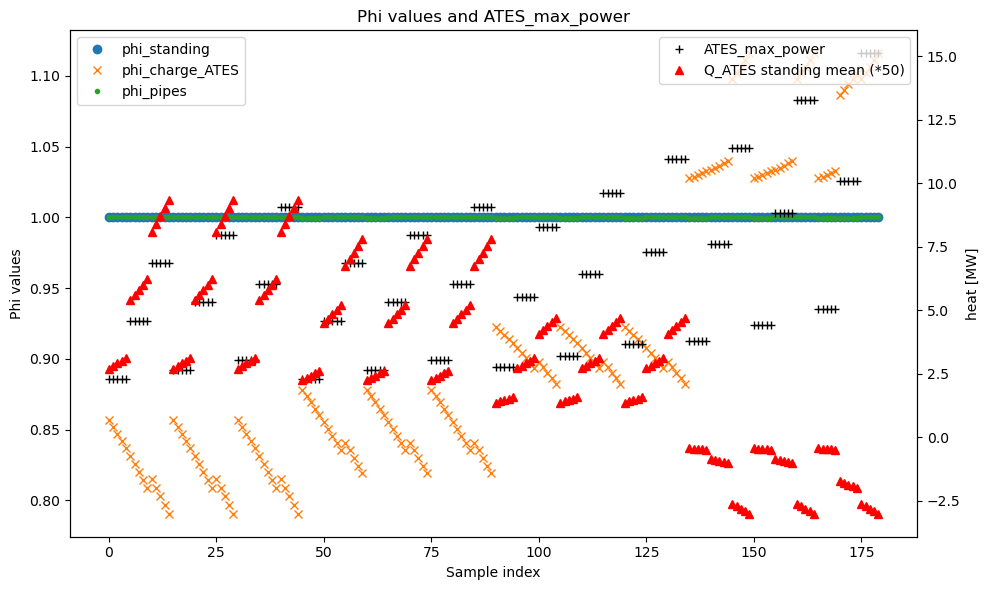

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot phi_standing, phi_charge_ATES, phi_pipes on left y-axis
ax1.plot(df_results_I['phi_standing'], label='phi_standing', linestyle='', marker='o')
ax1.plot(df_results_I['phi_charge_ATES'], label='phi_charge_ATES', linestyle='', marker='x')
ax1.plot(df_results_I['phi_pipes'], label='phi_pipes', linestyle='', marker='.')
ax1.set_ylabel('Phi values')
ax1.set_xlabel('Sample index')
ax1.legend(loc='upper left')

# Plot ATES_max_power on right y-axis
ax2 = ax1.twinx()
ax2.plot(df_results_I['ATES_max_power'], color='black', label='ATES_max_power', linestyle='', marker='+')
ax2.plot(df_results_I['Q_ATES_standing_mean']*50, color='red', label='Q_ATES standing mean (*50)', linestyle='', marker='^')

ax2.set_ylabel('heat [MW]', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('Phi values and ATES_max_power')
plt.tight_layout()
plt.show()


import os

# Define the ranges for each variable
phi_s_range = np.array([0.98, 0.99, 1.0])
phi_c_range = np.array([0.7, 0.8, 0.9])
elpr_range = np.array([80, 100, 120])  # Example values, adjust as needed
drc_range = np.array([500, 1000, 1500])
CapTT_range = np.array([100, 200, 300])  # Example values, adjust as needed
intr_range = np.array([0.02, 0.04, 0.06])

os.makedirs("optimization_2_results", exist_ok=True)

for phi_s in phi_s_range:
    for phi_c in phi_c_range:
        for elpr in elpr_range:
            for drc in drc_range:
                for CapTT in CapTT_range:
                    for intr in intr_range:
                        # Run the optimization with the current parameters
                        m = optimization(
                            depth_ATES, ATES_max_power, time_index_H, temperature_heat,
                            phi_s, phi_c, phi_pipes, heat_demand, P_pump, COP_hp,
                            elpr, drilling_costs=drc, Capex_TTES=CapTT, interest=intr
                        )
                        # Collect results in a DataFrame (example: ATES_capacity)
                        df_result = pd.DataFrame({
                            "ATES_capacity": [m.solution.ATES_capacity.values]
                        })
                        # Create filename with short variable names and values
                        filename = f"optimization_2_results/phi_s_{phi_s}_phi_c_{phi_c}_elpr_{elpr}_drc_{drc}_CapTT_{CapTT}_intr_{intr}.csv"
                        df_result.to_csv(filename, index=False)

ATES_porosity = np.arange(0.28, 0.33, 0.01)
results = []

for porosity in ATES_porosity:
    ATES_max_power, phi_standing, phi_charge_ATES, phi_pipes, P_pump = ATES_complete_setup(hydr_cond, layer_thickness, porosity, depth_ATES, temperature_ground, heat_capacity_solid, lambda_stand)
    m = optimization(depth_ATES, ATES_max_power, time_index_H, temperature_heat, phi_standing, phi_pipes, phi_charge_ATES, heat_demand, P_pump, COP_hp, electricity_price, drilling_costs=userinput.drilling_costs)
    # Example: store objective value and parameter
    results.append({
        "ATES_max_capacity": m.solution.ATES_capacity,
    })

# Print or process results
for res in results:
    print(results)

ATES_drilling_costs = np.arange(500, 1501, 250)
results = []

for drilling_costs in ATES_drilling_costs:
    ATES_max_power, phi_standing, phi_charge_ATES, phi_pipes, P_pump = ATES_complete_setup(hydr_cond, layer_thickness, porosity, depth_ATES, temperature_ground, heat_capacity_solid, lambda_stand)
    m = optimization(depth_ATES, ATES_max_power, time_index_H, temperature_heat, phi_standing, phi_pipes, phi_charge_ATES, heat_demand, P_pump, COP_hp, electricity_price, drilling_costs=userinput.drilling_costs)
    # Example: store objective value and parameter
    results.append({
        "ATES_max_capacity": m.solution.ATES_capacity,
    })

# Print or process results
for res in results:
    print(f"ATES_max_capacity: {results}")

ATES_depth = np.arange(250, 1501, 250)
results = []

for depth_ATES in ATES_depth:
    ATES_max_power, phi_standing, phi_charge_ATES, phi_pipes, P_pump = ATES_complete_setup(hydr_cond, layer_thickness, porosity, depth_ATES, temperature_ground, heat_capacity_solid, lambda_stand)
    m = optimization(depth_ATES, ATES_max_power, time_index_H, temperature_heat, phi_standing, phi_pipes, phi_charge_ATES, heat_demand, P_pump, COP_hp, electricity_price, drilling_costs=userinput.drilling_costs)
    # Example: store objective value and parameter
    results.append({
        "ATES_max_capacity": m.solution.ATES_capacity,
    })

# Print or process results
for res in results:
    print(results)

In [ ]:
from ATES_table import ATES_examples
ATES_examples

,Depth,Wells,Flow_m3_h,Capacity_MW,Flow_per_well_m3s,DN,dT,dP_real,U_value,Q_pipe,phi,P_Pump
0,130.0,4,500.0,8.30,0.034722,500.0,14.297277,4.691900,10.714286,87515.795350,0.086625,0.651653
1,NaN,7,1100.0,20.00,0.043651,100.0,15.659668,NaN,10.714286,NaN,NaN,NaN
2,NaN,2,200.0,1.40,0.027778,100.0,6.028972,NaN,10.714286,NaN,NaN,NaN
3,240.0,2,2.0,NaN,0.000278,200.0,NaN,2.706866,10.714286,64627.048874,NaN,0.001504
4,65.0,2,100.0,1.20,0.013889,300.0,10.335381,7.240587,10.714286,26254.738605,0.043708,0.201127
5,110.0,10,5.0,NaN,0.000139,200.0,NaN,0.620323,10.714286,29620.730734,NaN,0.000862
6,NaN,2,24.0,NaN,0.003333,100.0,NaN,NaN,10.714286,NaN,NaN,NaN
7,100.0,10,250.0,2.80,0.006944,300.0,9.646356,5.569682,10.714286,40391.905546,0.064827,0.386783
8,NaN,36,3000.0,20.00,0.023148,100.0,5.741878,NaN,10.714286,NaN,NaN,NaN
9,60.0,2,45.0,0.33,0.006250,300.0,6.316066,3.007628,10.714286,24235.143328,0.013434,0.037595
